# NLP 
- COMPSS 224B: Text Analysis for Political Risk
- Authors: Iris Malone and Mark Rosenberg
- Last Revised: 25 April 2025

This notebook will walk you through some basic functions using nltk and later gensim to conduct different types of text analysis. This includes:
- Dictionary Methods (Sentiment Analysis)
- Embeddings
- Topic Modeling

# 1. Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import os
import json
from collections import Counter
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import warnings

# Download necessary NLTK libraries
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    wordnet.synsets('computer')
except LookupError:
    nltk.download('wordnet')


Spacy is a powerful NLP tool. It automates a lot of preprocessing, tokenization, part of speech tag, and eentity recognition. It can be a little fickle to download but worth configuring https://spacy.io/usage

# Real-World Example: Presidential Inaugurals

*Source*: NLTK stores a number of preset datasets including presidential inaugurals. can be freely downloaded from <a href='http://www.nltk.org/nltk_data/'>NLTK Corpora</a> under the designation "68. C-Span Inaugural Address Corpus".

## 1. Load Data

In [78]:
path = os.getcwd()

file_names = sorted([file for file in os.listdir(f"{path}/inaugural")])
# Creates a speeches list from files   
speeches = []
for name in file_names:
    print(name)
    try:
        with open(f'inaugural/{name}', 'r', encoding='utf-8') as file:
            speeches.append(file.read())
    except UnicodeDecodeError:
        print(f"Warning: UTF-8 decoding failed for {name}. Trying 'latin-1' encoding.")
        try:
            with open(f'inaugural/{name}', 'r', encoding='latin-1') as file:
                speeches.append(file.read())
        except Exception as e:
            print(f"Error decoding {name} with 'latin-1': {e}")
            # Decide how to handle the error: skip the file, append an empty string, etc.
            speeches.append("")  # Appending an empty string for now
    except FileNotFoundError:
        print(f"Error: File not found: inaugural/{name}")
        speeches.append("")  # Handle file not found

.DS_Store
1789-Washington.txt
1793-Washington.txt
1797-Adams.txt
1801-Jefferson.txt
1805-Jefferson.txt
1809-Madison.txt
1813-Madison.txt
1817-Monroe.txt
1821-Monroe.txt
1825-Adams.txt
1829-Jackson.txt
1833-Jackson.txt
1837-VanBuren.txt
1841-Harrison.txt
1845-Polk.txt
1849-Taylor.txt
1853-Pierce.txt
1857-Buchanan.txt
1861-Lincoln.txt
1865-Lincoln.txt
1869-Grant.txt
1873-Grant.txt
1877-Hayes.txt
1881-Garfield.txt
1885-Cleveland.txt
1889-Harrison.txt
1893-Cleveland.txt
1897-McKinley.txt
1901-McKinley.txt
1905-Roosevelt.txt
1909-Taft.txt
1913-Wilson.txt
1917-Wilson.txt
1921-Harding.txt
1925-Coolidge.txt
1929-Hoover.txt
1933-Roosevelt.txt
1937-Roosevelt.txt
1941-Roosevelt.txt
1945-Roosevelt.txt
1949-Truman.txt
1953-Eisenhower.txt
1957-Eisenhower.txt
1961-Kennedy.txt
1965-Johnson.txt
1969-Nixon.txt
1973-Nixon.txt
1977-Carter.txt
1981-Reagan.txt
1985-Reagan.txt
1989-Bush.txt
1993-Clinton.txt
1997-Clinton.txt
2001-Bush.txt
2005-Bush.txt
2009-Obama.txt
2013-Obama.txt
2017-Trump.txt
2021-Biden.t

In [ ]:

def get_inaugural_speeches(start_year=1865):
    """
    Loads and preprocesses  inaugural speeches from the nltk corpus.

    Args:
        start_year (int, optional): The year to filter speeches from.
            Defaults to 1869 (Grant's presidency).

    Returns:
        pd.DataFrame: A DataFrame containing the preprocessed speech texts
                      and a 'president' column.
    """
    # Get all inaugural addresses from nltk
    try:
        # Attempt to get the inaugural addresses from nltk
        from nltk.corpus import inaugural
        files = inaugural.fileids()
        speeches = [inaugural.raw(file) for file in files]
    except LookupError:
        print("NLTK inaugural corpus not found. Downloading...")
        nltk.download('inaugural')  # Download the corpus
        files = inaugural.fileids()  #try again
        speeches = [inaugural.raw(file) for file in files]
    # Extract president names and years from fileids
    president_names = [file.split('-')[1].title() if 'pre' not in file else "NA" for file in files]
    president_years = [int(file.split('-')[0]) for file in files]  # convert year to int

    # Filter speeches since start_year
it    filtered_names = [name for i, name in enumerate(president_names) if president_years[i] >= start_year]
    filtered_years = [year for year in president_years if year >= start_year]

    # Create DataFrame.
    df = pd.DataFrame({
        'speech_text': filtered_speeches,
        'president': [f"{name} {year}" for name, year in zip(filtered_names, filtered_years)]
    })
    return filtered_speeches, df

In [80]:
speeches, inaugural_df = get_inaugural_speeches()

### Inspect Data

In [81]:
inaugural_df

,speech_text,president
0,Fellow-Countrymen:\n\nAt this second appearing...,Lincoln.Txt 1865
1,Citizens of the United States:\n\nYour suffrag...,Grant.Txt 1869
2,Fellow-Citizens:\n\nUnder Providence I have be...,Grant.Txt 1873
3,"Fellow citizens, we have assembled to repeat t...",Hayes.Txt 1877
4,Fellow-Citizens:\n\nWe stand to-day upon an em...,Garfield.Txt 1881
5,"Fellow citizens, in the presence of this vast ...",Cleveland.Txt 1885
6,"Fellow-Citizens, there is no constitutional or...",Harrison.Txt 1889
7,"My Fellow citizens, in obedience of the mandat...",Cleveland.Txt 1893
8,"Fellow citizens, In obedience to the will of t...",Mckinley.Txt 1897
9,"My fellow-citizens, when we assembled here on ...",Mckinley.Txt 1901


## 2. Preprocess Data
- Remove punctuation, numbers, emjois, urls, 
- Remove stop words
- Standardize casing
- Stemming or lemmatization

Recall:
- Stemming is the normalization preprocessing task focused on removing word affixes. 
- Lemmatization is the normalization preprocessing task that more carefully brings words down to their root forms. 



**Tokenization:**
Get unique tokens using the sentence tokenizer <a href='https://www.nltk.org/_modules/nltk/tokenize/punkt.html'>nltk.tokenize.PunktSentenceTokenizer()</a> class. Note: Spacy won't stem, only lemmatize because it is concentrated on part of speech tagging. This is probably good because it prevents loss of information/context.

**Part-of-Speech Tagging:**
To improve the performance of <a href="https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html">lemmatization</a> (bring a word to his root), each word in the processed text is assigned parts of speech tag, 
<a href="https://nlp.stanford.edu/software/tagger.shtml#:~:text=A%20Part%2DOf%2DSpeech%20Tagger,like%20'noun%2Dplural'.">Part-of-Speech Tagging</a> is the process of reading text in some language and assigns parts of speech to each word (and other token), such as noun, verb, adjective, etc.

Part-of-Speech tagging:

Apply spacy to get part of speech (noun, verb, adverb, adjective). Spacy works by:
- Takes the arguments:
    - ```word```, string data type.<br>
<br>
- Matches ```word``` with synonyms
- Tags ```word``` and count tags.<br> 
<br>
- Returns The most common tag, the tag with the highest count, ex: n for Noun, string data type.

**Named Entity Tagging:**
spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default trained pipelines can identify a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.

SpaCy Entity Types List
- PERSON: People, including fictional characters.
- NORP: Nationalities or religious/political groups.
- FAC: Buildings, airports, highways, bridges, etc.
- ORG: Companies, agencies, institutions, etc.
- GPE: Countries, cities, states.
- LOC: Non-GPE locations, mountain ranges, bodies of water.


#### Text cleaner function - customizable

In [82]:
import spacy
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
# Load NLTK's stop words
stop_words = set(stopwords.words('english'))

# we will also sometimes remove custom stopwords
custom_stopwords = {'us', "american", "america", 'united states', 'vice president', 'country', 'nation'}
stop_words.update(custom_stopwords)

def tidytext_clean(text, stop_words=None, max_freq=0.1, pos_filter=True):
    """
    Filters tokens in a text based on their Part-of-Speech (POS) tags using spaCy,
    removes stop words, and excludes tokens that appear too frequently.  Also removes
    numbers and alphanumerics.

    Args:
        text (str): The input text.
        stop_words (set, optional): A set of stop words to exclude. Defaults to None.
        max_freq (float, optional): Maximum document frequency for a token (0 to 1).
            Tokens exceeding this frequency are excluded. Defaults to 0.1.
        pos_filter (bool, optional): Whether to filter tokens by POS tags.
            Defaults to True. If True, only adjectives, nouns, proper nouns,
            and verbs are considered.

    Returns:
        str: A string containing the cleaned text with filtered tokens.
              Returns an empty string if no matching tokens are found.
    """
    if not text:
        return ""

    doc = nlp(text)
    filtered_tokens = []

    if pos_filter:
        # Filter tokens based on POS tags
        for token in doc:
            if token.pos_ in ["ADJ", "NOUN", "PROPN", "VERB"] and not token.like_num and token.is_alpha:  # Changed based on example
                filtered_tokens.append(token.lemma_.lower())
    else:
        # If not filtering by POS, use all tokens
        filtered_tokens = [token.lemma_.lower() for token in doc if not token.like_num and token.is_alpha]

    if not filtered_tokens:
        return ""

    if stop_words:
        filtered_tokens = [token for token in filtered_tokens if token not in stop_words]

    token_counts = Counter(filtered_tokens)
    total_tokens = len(filtered_tokens)

    # Remove frequent tokens
    if max_freq > 0:
        filtered_tokens = [token for token in filtered_tokens if token_counts[token] <= total_tokens * max_freq]

    return " ".join(filtered_tokens)



*Example:* Apply tidytext clean function to Lincoln 2 Inaugural

In [7]:
#Original text
speeches[0]

'Fellow-Countrymen:\n\nAt this second appearing to take the oath of the Presidential office there is less occasion for an extended address than there was at the first. Then a statement somewhat in detail of a course to be pursued seemed fitting and proper. Now, at the expiration of four years, during which public declarations have been constantly called forth on every point and phase of the great contest which still absorbs the attention and engrosses the energies of the nation, little that is new could be presented. The progress of our arms, upon which all else chiefly depends, is as well known to the public as to myself, and it is, I trust, reasonably satisfactory and encouraging to all. With high hope for the future, no prediction in regard to it is ventured.\n\nOn the occasion corresponding to this four years ago all thoughts were anxiously directed to an impending civil war. All dreaded it all sought to avert it. While the inaugural address was being delivered from this place, dev

In [8]:
clean_speech = tidytext_clean(speeches[0])
clean_speech

'fellow countrymen appear take oath presidential office be less occasion extended address be statement detail course pursue seem fitting proper expiration year public declaration call point phase great contest absorb attention engross energy nation little new present progress arm depend know public trust satisfactory encouraging high hope future prediction regard venture occasion correspond year thought direct impending civil war dread seek avert inaugural address deliver place devote save union war urgent agent city seek destroy war seek dissolve union divide effect negotiation party deprecate war make war let nation survive other accept war let perish war come whole population color slave distribute union localize southern part slave constitute peculiar powerful interest know interest cause war strengthen perpetuate extend interest object insurgent rend union war government claim right more restrict territorial enlargement party expect war magnitude duration attain anticipate cause c

In [9]:
type(clean_speech).__name__

'str'

Apply to our larger set of data

In [10]:
clean_inaugural_dtm = []
# Preprocessing loop
for speech in speeches:
    processed_speech = tidytext_clean(speech)
    #store information in a list for each speech
    clean_inaugural_dtm.append(processed_speech)

In [11]:
print('Lincoln 2nd inaugural')
clean_inaugural_dtm[0]

#print('Trump 2nd inaugural')
#clean_inaugural_dtm[40]

Lincoln 2nd inaugural


'fellow countrymen appear take oath presidential office be less occasion extended address be statement detail course pursue seem fitting proper expiration year public declaration call point phase great contest absorb attention engross energy nation little new present progress arm depend know public trust satisfactory encouraging high hope future prediction regard venture occasion correspond year thought direct impending civil war dread seek avert inaugural address deliver place devote save union war urgent agent city seek destroy war seek dissolve union divide effect negotiation party deprecate war make war let nation survive other accept war let perish war come whole population color slave distribute union localize southern part slave constitute peculiar powerful interest know interest cause war strengthen perpetuate extend interest object insurgent rend union war government claim right more restrict territorial enlargement party expect war magnitude duration attain anticipate cause c

We might also want to just translate the DTM into individual sentences for analysis

In [12]:
def dtm_pos(speech):
    """
    Processes a single speech to be compatible with get_document_sentiment.

    Args:
        speech (str): The raw text of the speech.

    Returns:
        list: A list of sentences, where each sentence is a list of
              (word, pos, tag) tuples.
    """
    doc = nlp(speech)
    sentences = []
    for sent in doc.sents:
        sentence = [(token.lemma_, token.pos_, token.tag_) for token in sent]
        sentences.append(sentence)
    return sentences

A nice feature of spacy is that it provides a lot of extra meta information for analysis if we want. For example, we could look at the data in another way:

In [13]:
def extract_spacy_meta(text):
    """
   Extract meta data raw lemma, position of speech, and tag 
    """
    cleaned_text = tidytext_clean(text)  # Clean the speech
    sentence_tokenizer = PunktSentenceTokenizer()
    sentence_tokenized_speech = sentence_tokenizer.tokenize(cleaned_text)

    processed_sentences = []
    all_named_entities = []

    for sentence in sentence_tokenized_speech:
        doc = nlp(sentence)
        processed_sentences.append(
            [(token.lemma_, token.pos_, token.tag_) for token in doc]
        )
        all_named_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

    return processed_sentences#, all_named_entities

In [14]:
#Look at spacy pos in 2nd lincoln
extract_spacy_meta(speeches[0])

[[('fellow', 'ADJ', 'JJ'),
  ('countryman', 'NOUN', 'NNS'),
  ('appear', 'VERB', 'VBP'),
  ('take', 'VERB', 'VBP'),
  ('oath', 'ADJ', 'JJ'),
  ('presidential', 'ADJ', 'JJ'),
  ('office', 'NOUN', 'NN'),
  ('be', 'AUX', 'VB'),
  ('less', 'ADJ', 'JJR'),
  ('occasion', 'NOUN', 'NN'),
  ('extended', 'ADJ', 'JJ'),
  ('address', 'NOUN', 'NN'),
  ('be', 'AUX', 'VB'),
  ('statement', 'NOUN', 'NN'),
  ('detail', 'NOUN', 'NN'),
  ('course', 'NOUN', 'NN'),
  ('pursue', 'PROPN', 'NNP'),
  ('seem', 'VERB', 'VB'),
  ('fit', 'VERB', 'VBG'),
  ('proper', 'ADJ', 'JJ'),
  ('expiration', 'NOUN', 'NN'),
  ('year', 'NOUN', 'NN'),
  ('public', 'ADJ', 'JJ'),
  ('declaration', 'NOUN', 'NN'),
  ('call', 'NOUN', 'NN'),
  ('point', 'NOUN', 'NN'),
  ('phase', 'NOUN', 'NN'),
  ('great', 'ADJ', 'JJ'),
  ('contest', 'NOUN', 'NN'),
  ('absorb', 'VERB', 'VB'),
  ('attention', 'NOUN', 'NN'),
  ('engross', 'NOUN', 'NN'),
  ('energy', 'NOUN', 'NN'),
  ('nation', 'NOUN', 'NN'),
  ('little', 'ADJ', 'JJ'),
  ('new', 'ADJ', '

In [15]:
#Look at spacy pos in 2nd trump
extract_spacy_meta(speeches[40])

[[('thank', 'VERB', 'VBP'),
  ('thank', 'VERB', 'VBP'),
  ('thank', 'VERB', 'VBP'),
  ('vice', 'NOUN', 'NN'),
  ('president', 'PROPN', 'NNP'),
  ('vance', 'NOUN', 'NN'),
  ('speaker', 'NOUN', 'NN'),
  ('johnson', 'PROPN', 'NNP'),
  ('senator', 'PROPN', 'NNP'),
  ('thune', 'PROPN', 'NNP'),
  ('chief', 'PROPN', 'NNP'),
  ('justice', 'PROPN', 'NNP'),
  ('roberts', 'PROPN', 'NNP'),
  ('justice', 'PROPN', 'NNP'),
  ('supreme', 'PROPN', 'NNP'),
  ('court', 'PROPN', 'NNP'),
  ('united', 'PROPN', 'NNP'),
  ('states', 'PROPN', 'NNP'),
  ('president', 'PROPN', 'NNP'),
  ('clinton', 'PROPN', 'NNP'),
  ('president', 'PROPN', 'NNP'),
  ('bush', 'PROPN', 'NNP'),
  ('president', 'PROPN', 'NNP'),
  ('obama', 'PROPN', 'NNP'),
  ('president', 'PROPN', 'NNP'),
  ('biden', 'PROPN', 'NNP'),
  ('vice', 'PROPN', 'NNP'),
  ('president', 'PROPN', 'NNP'),
  ('harris', 'PROPN', 'NNP'),
  ('fellow', 'PROPN', 'NNP'),
  ('citizen', 'PROPN', 'NNP'),
  ('golden', 'PROPN', 'NNP'),
  ('age', 'PROPN', 'NNP'),
  ('americ

Look at linguistic annotations:
https://spacy.io/usage/spacy-101
- Text: The original word text.
- Lemma: The base form of the word.
- POS: The simple UPOS part-of-speech tag.
- Tag: The detailed part-of-speech tag.
- Dep: Syntactic dependency, i.e. the relation between tokens.
- Shape: The word shape – capitalization, punctuation, digits.
- is alpha: Is the token an alpha character?
- is stop: Is the token part of a stop list, i.e. the most common words of the language?

Use spacy.explain("XXX") to get understanding


Spacy will tell us parts of speech assigned to each token

In [16]:
print("american token is:", spacy.explain('JJ'))
print("allow token is:", spacy.explain('VBP'))
print("Obama token is:", spacy.explain('NNP'))

american token is: adjective (English), other noun-modifier (Chinese)
allow token is: verb, non-3rd person singular present
Obama token is: noun, proper singular


Spacy can also allow us to examine different entities

In [17]:
#index to trump second inaugrual with index 40
doc = nlp(speeches[40])  # Process the speech at the given index
entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities (ent) in individual doc
print(f"Named entities in speech:")
if entities:
    for entity, label in entities:
        print(f"{entity}: {label}")

Named entities in speech:
Vance: PERSON
Johnson: PERSON
Thune: PERSON
Roberts: PERSON
the Supreme Court: ORG
the United States: GPE
Clinton: PERSON
Bush: PERSON
Obama: PERSON
Biden: PERSON
Harris: PERSON
America: GPE
this day: DATE
every single day: DATE
Trump: PERSON
America: GPE
first: ORDINAL
the Justice Department: ORG
America: GPE
America: GPE
first: ORDINAL
the United States of America: GPE
today: DATE
many years: DATE
American: NORP
American: NORP
North: ORG
many months ago: DATE
Los Angeles: GPE
weeks ago: DATE
today: DATE
Americaâs: PERSON
Americaâs: NORP
the past eight years: DATE
250-year: DATE
Just a few months ago: DATE
Pennsylvania: GPE
America: GPE
American: NORP
American: NORP
January 20th, 2025: DATE
Liberation Day: EVENT
African Americans: NORP
Hispanic Americans: NORP
Asian Americans: NORP
seven: CARDINAL
millions: CARDINAL
Black: NORP
Hispanic: NORP
Iâve: CARDINAL
the years: DATE
Today: DATE
Martin Luther King Day: PERSON
America: GPE
Constitution: LAW
Today: 

In [ ]:
from collections import Counter
#counter is how we will create count vectors of tokens
print("Value Counts of People in Trump Inaugural:")
person_entities_speech_trump = [
    (entity, label) for entity, label in entities if label == "PERSON"
    ]
entity_counts = Counter(person_entities_speech_trump)
for (entity, label), count in entity_counts.items():
     print(f"- {entity}: {count}")

print("Value Counts of Geopolitical Entities in Trump Inaugural:")
gpe_entities_speech_trump = [
    (entity, label) for entity, label in entities if label == "GPE"
    ]
entity_counts = Counter(gpe_entities_speech_trump)
for (entity, label), count in entity_counts.items():
     print(f"- {entity}: {count}")



Value Counts of People in Trump Inaugural:
- Vance: 1
- Johnson: 1
- Thune: 1
- Roberts: 1
- Clinton: 1
- Bush: 1
- Obama: 1
- Biden: 1
- Harris: 1
- Trump: 1
- Americaâs: 1
- Martin Luther King Day: 1
- William McKinley: 1
- McKinley: 1
- Teddy Roosevelt: 1
- God: 1
Value Counts of Geopolitical Entities in Trump Inaugural:
- the United States: 1
- America: 15
- the United States of America: 2
- Los Angeles: 2
- Pennsylvania: 1
- Remain: 1
- Mexico: 1
- US: 1
- United States: 1
- Panama: 2
- the United Spatesâthe United States: 1
- China: 2
- The United States: 1
- colonies: 1
- New York: 1
- Philadelphia: 1
- Phoenix: 1
- Chicago: 1
- Miami: 1
- Houston: 1
- Washington, DC: 1


We might also want to look for custom words. We do this by counting the number of words in our custom dictionary.

In [ ]:
#get corpus for first trump inaugural
text = inaugural_df['speech_text'][38]

# create dtm
doc = nlp(text)
# preprocess and tokenize
tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]

# count each token frequency to create count vector
word_counts = Counter(tokens)

# Define target words
# consider lemmatization
target_words = ['patriot', 'obama', 'carnage']

# Get their frequencies from word counts
frequencies = {word: word_counts[word] for word in target_words}

print(frequencies)


{'patriot': 0, 'obama': 3, 'carnage': 1}


**Optional:** A few extra accessories in the spacy package (they have a nice short tutorial on website recommend if you want to learn more...)

Spacy by default will do unigrams, but we can also expand to n-grams. This can help fix, for example, United States vs United States of America vs America

In [19]:
from spacy_ngram import NgramComponent 
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacy-ngram') #you can build out some very nice pipelines here to automate multiple tasks as you'll see
text = 'Thank you.  Thank you very much, everybody.  (Applause.)  Wow.  Thank you very, very much. Vice President Vance, Speaker Johnson, Senator Thune, Chief Justice Roberts, justices of the Supreme Court of the United States, President Clinton, President Bush, President Obama, President Biden, Vice President Harris, and my fellow citizens, the golden age of America begins right now.  (Applause.)   From this day forward, our country will flourish and be respected again all over the world.  We will be the envy of every nation, and we will not allow ourselves to be taken advantage of any longer.  During every single day of the Trump administration, I will, very simply, put America first.  (Applause.).'
doc = nlp(text)
print(doc._.ngram_2)

['thank_thank', 'thank_everybody', 'everybody_applause', 'applause_wow', 'wow_thank', 'thank_vice', 'vice_president', 'president_vance', 'vance_speaker', 'speaker_johnson', 'johnson_senator', 'senator_thune', 'thune_chief', 'chief_justice', 'justice_roberts', 'roberts_justice', 'justice_supreme', 'supreme_court', 'court_united', 'united_states', 'states_president', 'president_clinton', 'clinton_president', 'president_bush', 'bush_president', 'president_obama', 'obama_president', 'president_biden', 'biden_vice', 'vice_president', 'president_harris', 'harris_fellow', 'fellow_citizen', 'citizen_golden', 'golden_age', 'age_america', 'america_begin', 'begin_right', 'right_applause', 'applause_day', 'day_forward', 'forward_country', 'country_flourish', 'flourish_respect', 'respect_world', 'world_envy', 'envy_nation', 'nation_allow', 'allow_advantage', 'advantage_long', 'long_single', 'single_day', 'day_trump', 'trump_administration', 'administration_simply', 'simply_america', 'america_applau

Another way is to create a ruler in spacy. This allows us to set custom entity identification rules. 

In [20]:
from spacy.pipeline import EntityRuler
ruler = EntityRuler(nlp)

ruler = nlp.add_pipe("entity_ruler", before="ner") # Add the string name of the factory

patterns = [
    {"pattern": "the United States of America", "label": "GPE"},
    {"pattern": "United States of America", "label": "GPE"},
    {"pattern": "the United States", "label": "GPE"},
    {"pattern": "United States", "label": "GPE"},
    {"pattern": "USA", "label": "GPE"}, # You might want to include abbreviations too
]

ruler.add_patterns(patterns) # Add patterns to the ruler *after* adding it to the pipeline

text1 = "I love the United States of America."
text2 = "We live in the United States."
text3 = "The USA is a large country."

doc1 = nlp(text1)
doc2 = nlp(text2)
doc3 = nlp(text3)

print("Entities in doc1:")
for ent in doc1.ents:
    print(ent.text, ent.label_)

print("\nEntities in doc2:")
for ent in doc2.ents:
    print(ent.text, ent.label_)

print("\nEntities in doc3:")
for ent in doc3.ents:
    print(ent.text, ent.label_)

Entities in doc1:
the United States of America GPE

Entities in doc2:
the United States GPE

Entities in doc3:
USA GPE


# 2. Dictionary

## 2A. Sentiment Analysis

Motivation: Let's extend Dodds and Danforth (2009) to look at recent inaugurals

In [21]:
import nltk
#algorithm (counter) is sentiment intensity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

# Download VADER lexicon from nltk
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')


In [ ]:
def get_document_sentiment(document):
    """
    Calculates sentiment scores and word count for a single document,
    including compound and neutral scores. 
    """
    analyzer = SentimentIntensityAnalyzer()
    positive_score = 0
    negative_score = 0
    word_count = 0
    compound_scores = []
    neutral_scores = []

    for sentence in document:
        for word_token in sentence:  #for each token in sentence
            word = word_token[0]  # Access the token
            vs = analyzer.polarity_scores(word)
            if vs['pos'] > vs['neg']:
                positive_score += 1
            elif vs['neg'] > vs['pos']:
                negative_score += 1
            compound_scores.append(vs['compound'])
            neutral_scores.append(vs['neu'])
            word_count += 1

    net_sentiment = 0.0
    avg_compound = 0.0
    avg_neutral = 0.0

    if word_count > 0:
        net_sentiment = (positive_score - negative_score) / word_count
        #"compound score" is a normalized score that represents the overall sentiment of a piece of text, ranging from -1 (most negative) to +1 (most positive)
        avg_compound = sum(compound_scores) / len(compound_scores)
        avg_neutral = sum(neutral_scores) / len(neutral_scores)

    return {
        'net_sentiment': net_sentiment,
        'positive_score': positive_score,
        'negative_score': negative_score,
        'word_count': word_count,
        'compound_score': avg_compound,
        'neutral_score': avg_neutral,
    }

Mechanics: Vader works by looking at the part of speech and then assinging a polarity score based on that. This helps it capture intensifiers. But it also means you need to set up your spacy df to already have that tag in place. Luckily we did this above when we created extract_spacy_meta verison of our DTM
 

In [23]:
tidytext_clean(speeches[0])

'fellow countrymen appear take oath presidential office be less occasion extended address be statement detail course pursue seem fitting proper expiration year public declaration call point phase great contest absorb attention engross energy nation little new present progress arm depend know public trust satisfactory encouraging high hope future prediction regard venture occasion correspond year thought direct impending civil war dread seek avert inaugural address deliver place devote save union war urgent agent city seek destroy war seek dissolve union divide effect negotiation party deprecate war make war let nation survive other accept war let perish war come whole population color slave distribute union localize southern part slave constitute peculiar powerful interest know interest cause war strengthen perpetuate extend interest object insurgent rend union war government claim right more restrict territorial enlargement party expect war magnitude duration attain anticipate cause c

Apply sentiment analysis to Lincoln 2nd inaugural

In [24]:
get_document_sentiment(extract_spacy_meta(speeches[0]))

{'net_sentiment': 0.02877697841726619,
 'positive_score': 40,
 'negative_score': 32,
 'word_count': 278,
 'compound_score': 0.0053881294964028765,
 'neutral_score': 0.7410071942446043}

Apply this to all speeches and append to df

In [25]:
document_sentiments_list = []
for i, speech in enumerate(speeches):
    cleaned_speech = tidytext_clean(speech)
    pos_speech = extract_spacy_meta(cleaned_speech)
    sentiment_data = get_document_sentiment(pos_speech)
    document_sentiments_list.append({
            'speech_id': i + 1,
            'positive_score': sentiment_data['positive_score'],
            'negative_score': sentiment_data['negative_score'],
            'compound_score': sentiment_data['compound_score'],
            'net_sentiment': sentiment_data['net_sentiment'],
            'neutral_score': sentiment_data['neutral_score'],
            'word_count': sentiment_data['word_count'],
        })

    df_sentiment = pd.DataFrame(document_sentiments_list)
    #print(df_sentiment)


Visualize the sentiment of different inaugurals

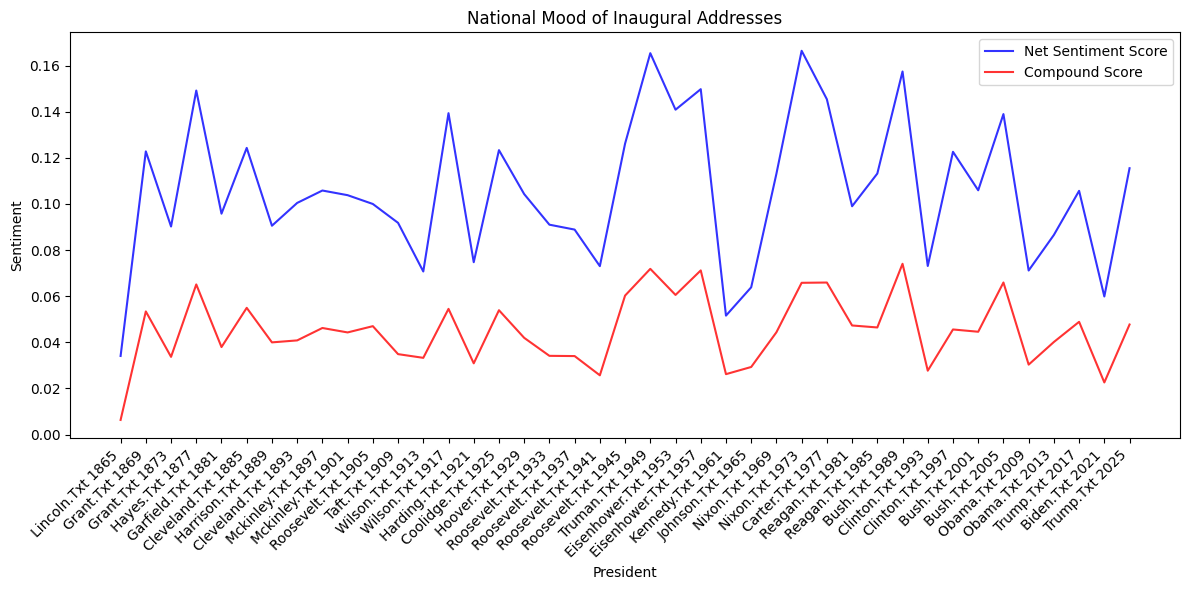

In [26]:
# 4. Merge the two dataframes on a common column.  Since the dataframes don't have a direct common column, we'll create one.
inaugural_df['speech_id'] = range(1, len(inaugural_df) + 1)  # Add speech_id to inaugural_df
df_viz = pd.merge(inaugural_df, df_sentiment, on='speech_id')

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(x='president', y='net_sentiment', data=df_viz, alpha=0.8, color='b', label='Net Sentiment Score')
sns.lineplot(x='president', y='compound_score', data=df_viz, alpha=0.8, color='r', label='Compound Score')
plt.title('National Mood of Inaugural Addresses')
plt.xlabel('President')
plt.ylabel('Sentiment')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [27]:
df_sentiment

,speech_id,positive_score,negative_score,compound_score,net_sentiment,neutral_score,word_count
0,1,41,32,0.006348,0.034091,0.723485,264
1,2,85,29,0.053398,0.122807,0.750000,456
2,3,71,23,0.033697,0.090226,0.823308,532
3,4,194,36,0.065103,0.149197,0.782814,1059
4,5,213,90,0.037944,0.095794,0.764019,1284
5,6,122,31,0.054952,0.124317,0.790984,732
6,7,283,114,0.039979,0.090568,0.787245,1866
7,8,157,68,0.040832,0.100451,0.746050,886
8,9,277,101,0.046216,0.105833,0.772700,1663
9,10,153,55,0.044292,0.103814,0.779661,944


In [28]:
df_viz.query("president == 'Lincoln.Txt 1865'")

,speech_text,president,speech_id,positive_score,negative_score,compound_score,net_sentiment,neutral_score,word_count
0,Fellow-Countrymen:\n\nAt this second appearing...,Lincoln.Txt 1865,1,41,32,0.006348,0.034091,0.723485,264


### Alternative Sentiment (distilbert) 
- Transformers option:
- Use colab because transformers typically requires more GPUs/cloud service 
- Base infrastructure is pytorch > tensorflow
- See: https://colab.research.google.com/github/mohd-faizy/06P_Sentiment_Analysis_With_Deep_Learning_Using_BERT/blob/master/01_Sentiment_Analysis_with_Deep_Learning_using_BERT.ipynb)

# 3. Distinctiveness

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import inaugural
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


def calculate_tfidf(df, top_n=20):
    """
    Calculates TF-IDF
    Args:
        df (pd.DataFrame): A DataFrame containing the speech texts
                          and a 'president' column.
        top_n (int, optional): The number of top TF-IDF words to return.

    Returns:
        tuple: A tuple containing two DataFrames:
            - tfidf_df:  TF-IDF DataFrame.
            - tf_df:  TF DataFrame.
    """

    vectorizer = TfidfVectorizer()
    cleaned_speeches = [tidytext_clean(text) for text in df['speech_text']]
    tfidf_matrix = vectorizer.fit_transform(cleaned_speeches)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_df['president'] = df['president']

    # Calculate TF
    tf_values = []
    for text in df['speech_text']:
        word_counts = Counter(text.split())
        total_words = len(text.split())
        tf_values.append({word: count / total_words for word, count in word_counts.items()})
    tf_df = pd.DataFrame(tf_values)
    tf_df['president'] = df['president']

    return tfidf_df, tf_df, vectorizer  # Return the vectorizer as well.



Calculate tf-idf

In [30]:
tfidf_df, tf_df, vectorizer = calculate_tfidf(inaugural_df)

    # Print the first few rows of the TF-IDF DataFrame
print("TF-IDF DataFrame:")
print(tfidf_df.head())


TF-IDF DataFrame:
   abandon  abandonment  abate  abdicate  abeyance  abhorring     abide  \
0      0.0          0.0    0.0       0.0  0.000000        0.0  0.000000   
1      0.0          0.0    0.0       0.0  0.061423        0.0  0.032996   
2      0.0          0.0    0.0       0.0  0.000000        0.0  0.000000   
3      0.0          0.0    0.0       0.0  0.000000        0.0  0.000000   
4      0.0          0.0    0.0       0.0  0.000000        0.0  0.000000   

   ability  abject      able  ...  yesterday     yield  york  yorktown  \
0   0.0000     0.0  0.000000  ...        0.0  0.000000   0.0  0.000000   
1   0.1066     0.0  0.000000  ...        0.0  0.000000   0.0  0.000000   
2   0.0000     0.0  0.000000  ...        0.0  0.000000   0.0  0.000000   
3   0.0000     0.0  0.040798  ...        0.0  0.022148   0.0  0.000000   
4   0.0000     0.0  0.000000  ...        0.0  0.019311   0.0  0.027662   

      young  your  yourself  youth  zeal   zealous  
0  0.000000   0.0       0.0    0.

In [55]:
print(tfidf_df.tail())

     abandon  abandonment  abate  abdicate  abeyance  abhorring     abide  \
36  0.026194          0.0    0.0       0.0       0.0        0.0  0.000000   
37  0.000000          0.0    0.0       0.0       0.0        0.0  0.000000   
38  0.000000          0.0    0.0       0.0       0.0        0.0  0.000000   
39  0.000000          0.0    0.0       0.0       0.0        0.0  0.000000   
40  0.000000          0.0    0.0       0.0       0.0        0.0  0.016358   

     ability  abject      able  ...  yesterday  yield      york  yorktown  \
36  0.024125     0.0  0.000000  ...   0.000000    0.0  0.000000       0.0   
37  0.000000     0.0  0.000000  ...   0.000000    0.0  0.000000       0.0   
38  0.000000     0.0  0.000000  ...   0.000000    0.0  0.000000       0.0   
39  0.000000     0.0  0.000000  ...   0.025861    0.0  0.000000       0.0   
40  0.000000     0.0  0.017615  ...   0.022179    0.0  0.027397       0.0   

       young  your  yourself     youth  zeal  zealous  
36  0.019047   0.0

Visualize the results

In [31]:
def plot_wordcloud(tfidf_df):
    """
    Generates and plots word clouds for select inaugural addresses
    based on TF-IDF values.

    Args:
        tfidf_df (pd.DataFrame): DataFrame containing TF-IDF values and 'president' column.
    """
    plt.figure(figsize=(12, 6))
    for i, president in enumerate(['Lincoln.Txt 1865', 'Trump.Txt 2025']):
        plt.subplot(1, 2, i + 1)
        # Get the TF-IDF values for the current president
        president_df = tfidf_df[tfidf_df['president'] == president].drop(columns=['president'])
        # Sum the TF-IDF values for each word across all documents
        word_tfidf = president_df.sum(axis=0)
        # Create a dictionary of word frequencies for the word cloud
        word_freq_dict = word_tfidf.to_dict()

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{president} Inaugural Address Word Cloud (TF-IDF)')
    plt.tight_layout()
    plt.show()

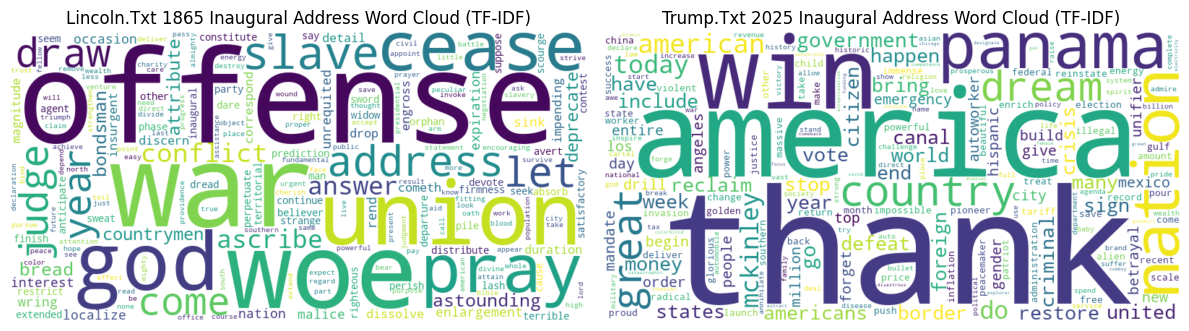

In [32]:
plot_wordcloud(tfidf_df)

# 4. Embeddings

Word embeddings (word vectors) are numeric representations of words, usually generated via dimensionality reduction on a word cooccurrence matrix for a large corpus. The vectors SpaCy uses are the GloVe vectors, Stanford's Global Vectors for Word Representation. These vectors can be used to calculate semantic similarity between words and documents.

## 4A. Document Vectorization

In [ ]:
import spacy
from collections import Counter
import string

nlp = spacy.load("en_core_web_sm")

#rerun tidytext but make sure output is just tokens instead of pos
def tidytext_clean(text, stop_words=None, max_freq=0.1, pos_filter=True):
    """
    Filters tokens in a text based on their Part-of-Speech (POS) tags using spaCy,
    removes stop words, and excludes tokens that appear too frequently.  Also removes
    numbers and alphanumerics.

    Args:
        text (str): The input text.
        stop_words (set, optional): A set of stop words to exclude. Defaults to None.
        max_freq (float, optional): Maximum document frequency for a token (0 to 1).
            Tokens exceeding this frequency are excluded. Defaults to 0.1.
        pos_filter (bool, optional): Whether to filter tokens by POS tags.
            Defaults to True. If True, only adjectives, nouns, proper nouns,
            and verbs are considered.

    Returns:
        list: A list containing the cleaned and filtered tokens.
              Returns an empty list if no matching tokens are found.
    """
    if not text:
        return []

    doc = nlp(text)
    filtered_tokens = []

    if pos_filter:
        # Filter tokens based on POS tags
        for token in doc:
            if token.pos_ in ["ADJ", "NOUN", "PROPN", "VERB"] and not token.like_num and token.is_alpha:
                filtered_tokens.append(token.lemma_.lower())
    else:
        # If not filtering by POS, use all tokens
        filtered_tokens = [token.lemma_.lower() for token in doc if not token.like_num and token.is_alpha]

    if not filtered_tokens:
        return []

    if stop_words:
        filtered_tokens = [token for token in filtered_tokens if token not in stop_words]

    token_counts = Counter(filtered_tokens)
    total_tokens = len(filtered_tokens)

    # Remove frequent tokens
    if max_freq > 0:
        filtered_tokens = [token for token in filtered_tokens if token_counts[token] <= total_tokens * max_freq]

    return filtered_tokens  # Changed return type to list

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_doc2vec_model(df):
    """
    Trains a Doc2Vec model on the inaugural speeches.

    Args:
        df (pd.DataFrame): DataFrame containing the 'speech_text' column.

    Returns:
        gensim.models.Doc2Vec: Trained Doc2Vec model.
    """
    # Tokenize the speeches into words
    tagged_data = [TaggedDocument(words=speech.split(), tags=[str(i)]) for i, speech in enumerate(df['speech_text'])]
    # Train the Doc2Vec model
    model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=40)
    return model

def get_doc_vectors(model, df):
    """
    Gets the Doc2Vec vectors for each inaugural speech.

    Args:
        model (gensim.models.Doc2Vec): Trained Doc2Vec model.
        df (pd.DataFrame): DataFrame containing the preprocessed speech texts.

    Returns:
        numpy.ndarray: A 2D array where each row represents the vector for a speech.
    """
    speech_vectors = [model.dv[str(i)] for i in range(len(df['speech_text']))]
    return np.array(speech_vectors)


Similar to last week, we might want to look at the similarity matrix. Instead of looking at Euclidean distance we will look at the cosine similarity.

In [ ]:

def plot_similarity_matrix(speech_vectors, df):
    """
    Calculates and plots the similarity matrix between inaugural speeches
    based on their Doc2Vec vectors.

    Args:
        speech_vectors (numpy.ndarray): 2D array of Doc2Vec vectors for each speech.
        df (pd.DataFrame): DataFrame containing the 'president' column for labels.
    """
    # Calculate the similarity matrix
    similarity_matrix = np.inner(speech_vectors, speech_vectors) / (np.linalg.norm(speech_vectors, axis=1)[:, None] * np.linalg.norm(speech_vectors, axis=1))

    # Set up the plot
    plt.figure(figsize=(20, 10))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                xticklabels=df['president'], yticklabels=df['president'])
    plt.title('Similarity Matrix of Inaugural Speeches')
    plt.xlabel('President')
    plt.ylabel('President')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



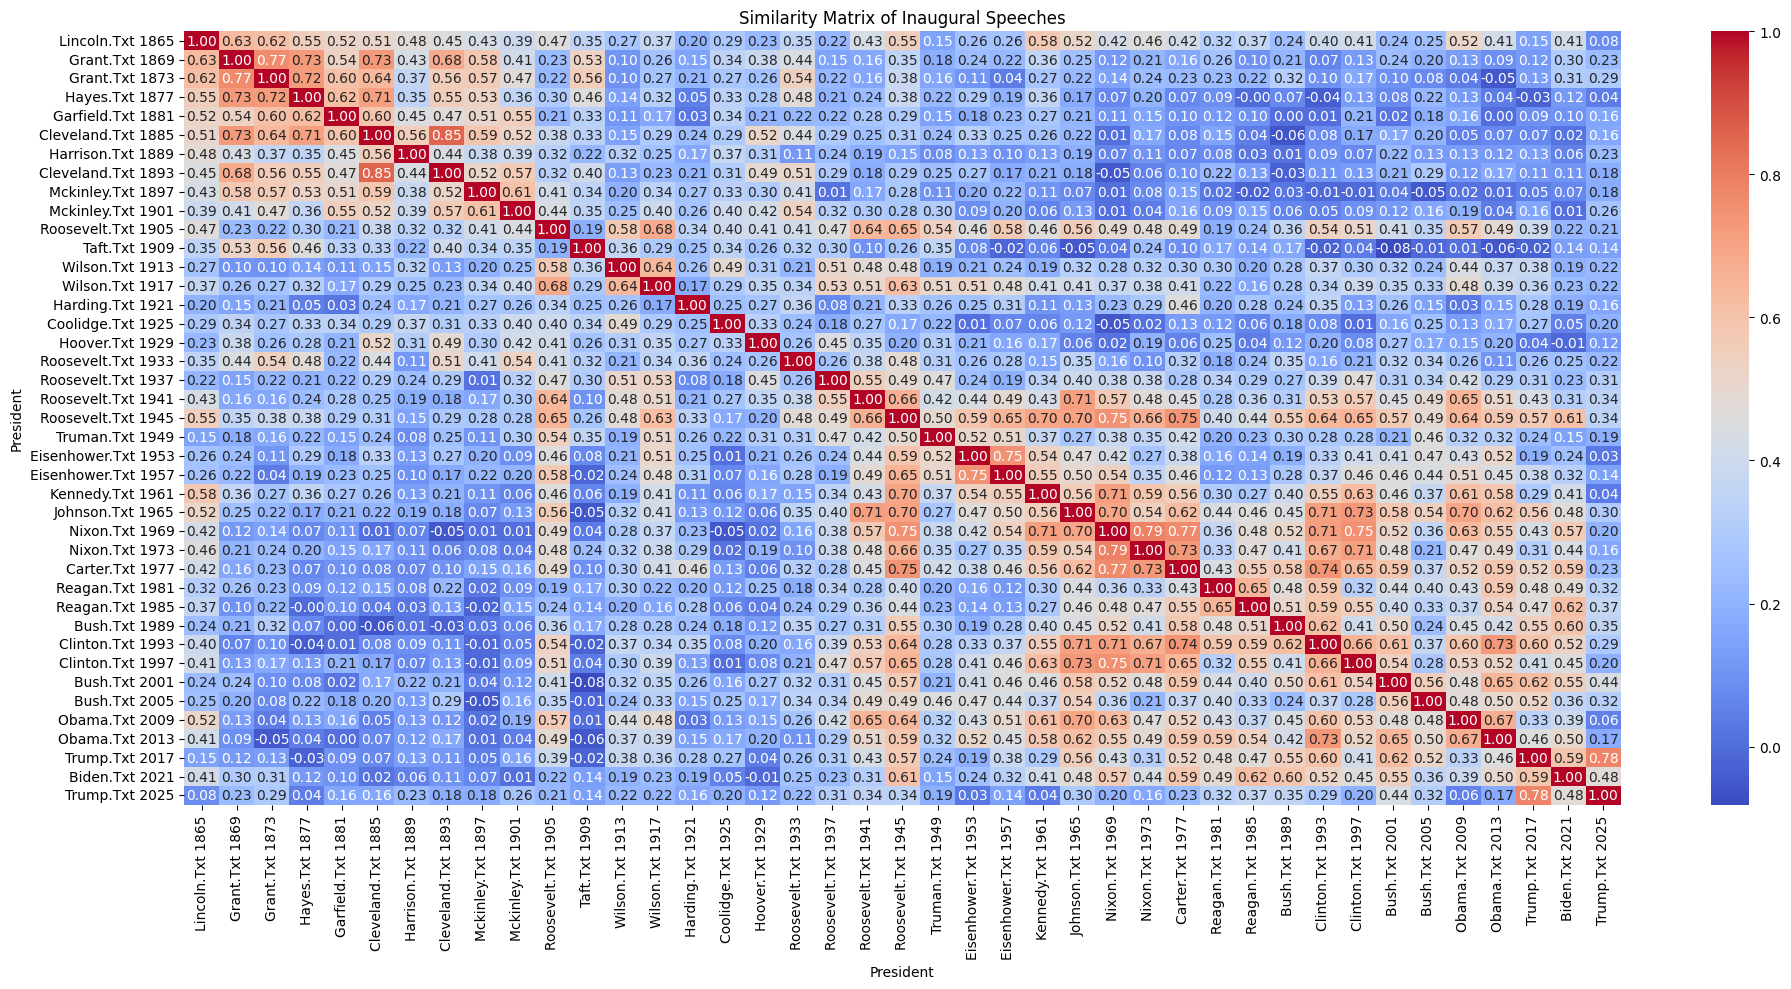

In [35]:

# Train the Doc2Vec model
doc2vec_model = train_doc2vec_model(inaugural_df)

    # Get the document vectors
speech_vectors = get_doc_vectors(doc2vec_model, inaugural_df)

    # Plot the similarity matrix
plot_similarity_matrix(speech_vectors, inaugural_df)

## 4B. Word Vectorization

The idea behind word embeddings is a theory known as the distributional hypothesis. This hypothesis states that words that co-occur in the same contexts tend to have similar meanings.
Word2Vec is a shallow neural network model that can build word embeddings using either continuous bag-of-words or continuous skip-grams.<br>
<br>
The word2vec method that I use to create word embeddings is based on continuous skip-grams. Skip-grams function similarly to n-grams, except instead of looking at groupings of n-consecutive words in a text, we can look at sequences of words that are separated by some specified distance between them.<br>
<br>
For this project, we want to create word embeddings model using the skip-grams word2vec model, within the USA presidential inaugural speeches context.    

In [36]:
import spacy
from collections import Counter
import string
from gensim.models import Word2Vec

nlp = spacy.load("en_core_web_sm")

def tidytext_clean(text, stop_words=None, max_freq=0.1, pos_filter=True):
    if not text:
        return []

    doc = nlp(text)
    filtered_tokens = []

    if pos_filter:
        # Filter tokens based on POS tags
        for token in doc:
            if token.pos_ in ["ADJ", "NOUN", "PROPN", "VERB"] and not token.like_num and token.is_alpha:
                filtered_tokens.append(token.lemma_.lower())
    else:
        # If not filtering by POS, use all tokens
        filtered_tokens = [token.lemma_.lower() for token in doc if not token.like_num and token.is_alpha]

    if not filtered_tokens:
        return []

    if stop_words:
        filtered_tokens = [token for token in filtered_tokens if token not in stop_words]

    token_counts = Counter(filtered_tokens)
    total_tokens = len(filtered_tokens)

    # Remove frequent tokens
    if max_freq > 0:
        filtered_tokens = [token for token in filtered_tokens if token_counts[token] <= total_tokens * max_freq]

    return filtered_tokens  # Changed return type to list

In [37]:
all_sentences = []
for speech in inaugural_df['speech_text']:
    cleaned_tokens = tidytext_clean(speech)
    all_sentences.append(cleaned_tokens)

word_embeddings = Word2Vec(sentences=all_sentences, window=5, min_count=1, workers=2, sg=1)
print(word_embeddings)
print(f"Vocabulary size: {word_embeddings.corpus_total_words}")

Word2Vec<vocab=5105, vector_size=100, alpha=0.025>
Vocabulary size: 39103


Compare word embeddings for 'great' - how do different presidents think about it?

In [ ]:
vec_word = 'great'
word_embeddings = Word2Vec(all_sentences, window=5, min_count=1, workers=2, sg=1)
# Word verctor representation
print(vec_word)
#examine raw values (note high dimensionality)
print(word_embeddings.wv[vec_word])

great
[-0.08054554  0.10004625  0.04307066 -0.03559093  0.13169628 -0.29853177
  0.23668016  0.2407163  -0.12829088 -0.01280167 -0.03403578 -0.22416322
 -0.10856988  0.16186307 -0.08479203 -0.01592004 -0.10117213 -0.36970693
  0.16462688 -0.33930412  0.02969399  0.0904685   0.09712704 -0.03893234
 -0.04848348 -0.08820031 -0.07349869 -0.19844413 -0.15866373  0.07238673
  0.3424465   0.00787267  0.11243929 -0.10045906 -0.09009863  0.34205365
  0.04225248 -0.2239687  -0.1636373  -0.37729678 -0.10914135 -0.30593792
 -0.09501661  0.10308261  0.28886154 -0.14034654 -0.07313079  0.02360781
  0.09979687  0.0937124   0.170814   -0.00637596 -0.00626812  0.15116486
 -0.17319217  0.07575785  0.3535685  -0.12768674 -0.34028274  0.05581938
 -0.06170924 -0.00609623 -0.10064987  0.08012253 -0.1732345   0.08575727
  0.06607897  0.08462095 -0.08838572  0.16327567 -0.20002472  0.04041182
  0.14632972  0.02113035  0.16163783  0.13610491 -0.0981744  -0.10357349
 -0.04425498 -0.0621306   0.02212592 -0.15630

Compare word embeddings in inaugurals

In [39]:
similar_to_word = 'government'
    
# Similar to 
print(similar_to_word)
# Calculate the cosine distance between word vectors outputting the 20 most similar words to the inputted word
similar_word_dist_vec = word_embeddings.wv.most_similar(similar_to_word, topn=20)
# Saves vocabulary_of_terms
# List of similar words and their vectors cosine distance relative to the inputted word
print(similar_word_dist_vec)

government
[('federal', 0.996093213558197), ('interest', 0.9949555397033691), ('control', 0.994942307472229), ('southern', 0.99442458152771), ('support', 0.9944207668304443), ('executive', 0.9943125247955322), ('local', 0.9942891001701355), ('authority', 0.9942852854728699), ('administration', 0.9941810965538025), ('state', 0.9940847158432007), ('court', 0.9940565228462219), ('legislative', 0.9939391016960144), ('duty', 0.9939355254173279), ('obligation', 0.993857741355896), ('reservation', 0.9938347339630127), ('elect', 0.9937782883644104), ('member', 0.9936250448226929), ('add', 0.9935992360115051), ('assume', 0.9935897588729858), ('foreign', 0.9934948682785034)]


In [40]:
similar_to_word = 'slavery'
    
# Similar to 
print(similar_to_word)
# Calculate the cosine distance between word vectors outputting the 20 most similar words to the inputted word
similar_word_dist_vec = word_embeddings.wv.most_similar(similar_to_word, topn=20)
# List of similar words and their vectors cosine distance relative to the inputted word
print(similar_word_dist_vec)

slavery
[('threaten', 0.9990283846855164), ('debate', 0.9988996982574463), ('join', 0.9988610148429871), ('culture', 0.9988534450531006), ('revolution', 0.9988503456115723), ('pride', 0.9988454580307007), ('decency', 0.9988445043563843), ('earn', 0.9988443851470947), ('play', 0.998843789100647), ('vote', 0.9988391399383545), ('long', 0.9988345503807068), ('politic', 0.9988338947296143), ('ally', 0.9988173246383667), ('triumph', 0.9988172650337219), ('hour', 0.9988123178482056), ('deny', 0.9988120198249817), ('development', 0.9988088607788086), ('battle', 0.9988059997558594), ('suffering', 0.9987978339195251), ('entire', 0.9987961649894714)]


In [83]:
similar_to_word = 'great'
    
# Similar to 
print(similar_to_word)
# Calculate the cosine distance between word vectors outputting the 20 most similar words to the inputted word
similar_word_dist_vec = word_embeddings.wv.most_similar(similar_to_word, topn=20)
# List of similar words and their vectors cosine distance relative to the inputted word
print(similar_word_dist_vec)

great
[('aspiration', 0.9972681999206543), ('strong', 0.9971672296524048), ('seek', 0.9971629977226257), ('become', 0.9970628023147583), ('mighty', 0.9970338940620422), ('preserve', 0.9970324635505676), ('lead', 0.9969789981842041), ('home', 0.9969725012779236), ('mankind', 0.9968981742858887), ('age', 0.9968460202217102), ('courage', 0.9967101812362671), ('victory', 0.9966993927955627), ('danger', 0.9966872930526733), ('truth', 0.996676504611969), ('proud', 0.9966734647750854), ('continue', 0.9966611266136169), ('fail', 0.996623694896698), ('ready', 0.9966106414794922), ('win', 0.9966055154800415), ('story', 0.9965517520904541)]


In [41]:
import pandas as pd
from collections import Counter

president_names = inaugural_df['president'].unique()

# Initialize an empty dictionary to store vocabularies for each president
presidents_vocabularies = {}

for president in president_names:
    # Get all speeches for the current president
    president_speeches = inaugural_df[inaugural_df['president'] == president]['speech_text'].tolist()

    # Clean the text of all speeches for the current president
    cleaned_speeches = [tidytext_clean(speech) for speech in president_speeches]

    # Flatten the list of lists of words into a single list of all words
    all_words = [word for speech in cleaned_speeches for word in speech]

    # Calculate the three most recurrent terms
    three_most_recurrent = [word[0] for word in Counter(all_words).most_common(3)]

    # Calculate the ten most recurrent terms (you had [:15], changed to [:10] as per column name)
    ten_most_recurrent = [word[0] for word in Counter(all_words).most_common(10)]

    # Get the vocabulary of unique terms
    terms_list = list(set(all_words))

    # Store the results in the dictionary
    presidents_vocabularies[president] = {
        'Three Most Recurrent Terms': three_most_recurrent,
        'Ten Most Recurrent Terms': ten_most_recurrent,
        'Terms List': terms_list
    }

# Create a DataFrame from the dictionary
df_presidents_vocabularies = pd.DataFrame.from_dict(presidents_vocabularies, orient='index')
# Display the DataFrame
print(df_presidents_vocabularies)

                             Three Most Recurrent Terms  \
Lincoln.Txt 1865                    [war, god, offense]   
Grant.Txt 1869                      [country, law, pay]   
Grant.Txt 1873                    [good, country, make]   
Hayes.Txt 1877             [country, government, party]   
Garfield.Txt 1881    [government, people, constitution]   
Cleveland.Txt 1885        [people, government, citizen]   
Harrison.Txt 1889                 [people, law, public]   
Cleveland.Txt 1893         [people, government, public]   
Mckinley.Txt 1897           [people, government, great]   
Mckinley.Txt 1901        [government, people, congress]   
Roosevelt.Txt 1905               [nation, people, have]   
Taft.Txt 1909              [government, make, business]   
Wilson.Txt 1913                      [great, life, man]   
Wilson.Txt 1917                  [own, purpose, nation]   
Harding.Txt 1921                  [world, america, war]   
Coolidge.Txt 1925                [country, great, have] 

### Selection of Presidents

We can analyze further, using word embeddings, the presidential vocabulary by combining the first five US presidents' inaugural speeches and compare the results with the results from last five US presidents' inaugural speeches.

Preprocessing the data:

In [42]:
# All words list
cleaned_speeches = [tidytext_clean(speech) for speech in inaugural_df['speech_text']]
first_5_presidents_all_words = [word for words in cleaned_speeches[:5] for word in words]
last_5_presidents_all_words = [word for words in cleaned_speeches[-5:]
                                                                                                       for word in words]

# Sentences list
first_5_presidents_sentences = [sentence for sentences in cleaned_speeches[:5] for sentence in sentences]
last_5_presidents_sentences = [sentence for sentences in cleaned_speeches[-5:]  for sentence in sentences]
# Vocabulary of terms:
first_5_presidents_vocabulary = list(set(first_5_presidents_all_words))
last_5_presidents_vocabulary = list(set(last_5_presidents_all_words))

In [43]:
first_5_presidents_all_words[:10]

['fellow',
 'countrymen',
 'appear',
 'take',
 'oath',
 'presidential',
 'office',
 'be',
 'less',
 'occasion']

In [44]:
#Look at intersecting words
intersection_vocabulary = set(first_5_presidents_vocabulary) & set(last_5_presidents_vocabulary)

print(f"Number of common words: {len(intersection_vocabulary)}")
print(f"Common words: {intersection_vocabulary}")

Number of common words: 615
Common words: {'reserve', 'bible', 'duty', 'gold', 'foreign', 'merit', 'good', 'restoration', 'lie', 'believer', 'wealth', 'hang', 'personal', 'hand', 'stand', 'decree', 'belong', 'judgment', 'race', 'supreme', 'strive', 'labor', 'blood', 'foundation', 'obligation', 'travel', 'change', 'inaugural', 'community', 'take', 'gain', 'return', 'patriotism', 'waterway', 'middle', 'issue', 'build', 'society', 'destiny', 'free', 'call', 'sum', 'reward', 'direct', 'govern', 'extraordinary', 'think', 'language', 'alarm', 'route', 'entire', 'nation', 'pass', 'product', 'open', 'proclaim', 'fear', 'member', 'mighty', 'chance', 'threaten', 'individual', 'period', 'interest', 'establish', 'course', 'prudent', 'wisdom', 'radical', 'object', 'bad', 'home', 'thing', 'color', 'serious', 'declaration', 'constitution', 'let', 'secure', 'elect', 'represent', 'claim', 'put', 'toil', 'sweep', 'time', 'revolution', 'recent', 'march', 'carry', 'believe', 'view', 'unite', 'citizen', 'k

Most frequently used terms:

In [45]:
# First five presidents
first_5_presidents_most_freq_words = Counter(first_5_presidents_all_words).most_common()
# 10 most frequently used words
print('First Five Presidents')
print(first_5_presidents_most_freq_words[:10])

# Last five presidents
last_5_presidents_most_freq_words = Counter(last_5_presidents_all_words).most_common()
# 10 most frequently used words
print('\nLast Five Presidents')
print(last_5_presidents_most_freq_words[:10])

First Five Presidents
[('government', 53), ('people', 39), ('country', 38), ('great', 37), ('nation', 37), ('make', 32), ('law', 32), ('good', 30), ('states', 29), ('constitution', 25)]

Last Five Presidents
[('america', 76), ('nation', 66), ('people', 47), ('do', 41), ('country', 41), ('american', 40), ('great', 39), ('today', 37), ('thank', 34), ('world', 34)]


In [46]:
print('First Post-1860 Presidents')
print([word[0] for word in first_5_presidents_most_freq_words[:3]])

print('\nLast Five Presidents')
print([word[0] for word in last_5_presidents_most_freq_words[:3]])

First Post-1860 Presidents
['government', 'people', 'country']

Last Five Presidents
['america', 'nation', 'people']


Word embeddings:

In [ ]:
first_5_presidents_word_embeddings = Word2Vec(sentences=[first_5_presidents_all_words],
                                             window=5,
                                             min_count=1,
                                             workers=2,
                                             #sg is skipgram
                                             sg=1)

last_5_presidents_word_embeddings = Word2Vec(sentences=[last_5_presidents_all_words],
                                            window=5,
                                            min_count=1,
                                            workers=2,
                                            sg=1)

Similar words:

In [48]:
first_last_pre_similar_to_word = 'fire'

# Calculate the cosine distance between word vectors outputting the 20 most similar words to the inputted word
first_5_pre_similar_word_dist = first_5_presidents_word_embeddings.wv.most_similar(first_last_pre_similar_to_word, topn=20)
last_5_pre_similar_word_dist = last_5_presidents_word_embeddings.wv.most_similar(first_last_pre_similar_to_word, topn=20)

# List of similar words and their vectors cosine distance relative to the inputted word
print(f'First five presidents {first_last_pre_similar_to_word}')
print(first_5_pre_similar_word_dist)
print(f'\nLast five presidents {first_last_pre_similar_to_word}')
print(last_5_pre_similar_word_dist)

First five presidents fire
[('prepare', 0.33858722448349), ('canal', 0.321086049079895), ('accomplishment', 0.31157174706459045), ('righteous', 0.299437940120697), ('varied', 0.29710209369659424), ('desire', 0.297098845243454), ('contract', 0.28145021200180054), ('add', 0.27924084663391113), ('birth', 0.27853304147720337), ('urgent', 0.27767542004585266), ('unmake', 0.27298060059547424), ('indicate', 0.2667481601238251), ('sympathy', 0.2655033469200134), ('interior', 0.2650982141494751), ('emancipate', 0.2621135115623474), ('variation', 0.258390873670578), ('sense', 0.2554008960723877), ('reflection', 0.2528665363788605), ('objection', 0.2528263032436371), ('parallel', 0.24987982213497162)]

Last five presidents fire
[('dream', 0.8898448348045349), ('begin', 0.8879232406616211), ('common', 0.8862075209617615), ('justice', 0.8850269317626953), ('america', 0.8845166563987732), ('god', 0.8841256499290466), ('united', 0.8839285373687744), ('carry', 0.8839282989501953), ('man', 0.8833824992

The cosine distance values of the most similar words are close to 1, the results are satisfying, better than ones from one president, the results are better due to the larger size of the corpus used to train the word embeddings models.

Most similar words, no cosine distances:

# 5. Clustering/Topic Modeling

## 5A. K-Means Clustering

Putting it all together: Let's take the different word embeddings within inaugurals and use that to cluster the speeches. 

Procedure:
1. Clean inaguural speeches
2. Get common vocabulary
3. Create word embeddings
4. Calculate average embedding for each inaugural
5. Cluster based on similar speech vectors. 


In [ ]:
import tabulate 
from sklearn.cluster import KMeans
def train_word2vec_model(df, vector_size=100, window=5, min_count=5, epochs=100):
    """
    Trains a Word2Vec model on the inaugural speeches.

    Args:
        df (pd.DataFrame): DataFrame containing the preprocessed speech texts.
        vector_size (int, optional): Dimensionality of the word vectors. Defaults to 100.
        window (int, optional): Maximum distance between the current and predicted word. Defaults to 5.
        min_count (int, optional): Ignores all words with total frequency lower than this. Defaults to 5.
        epochs (int, optional): Number of iterations (epochs) over the corpus. Defaults to 100.

    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    # Tokenize the speeches
    sentences = [speech.split() for speech in df['speech_text']]
    # Train Word2Vec model
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, epochs=epochs)
    return model

def get_speech_vectors(model, df):
    """
    Calculates the average Word2Vec vector for each inaugural speech.

    Args:
        model (Word2Vec): Trained Word2Vec model.
        df (pd.DataFrame): DataFrame containing the preprocessed speech texts.

    Returns:
        numpy.ndarray: A 2D array where each row represents the average vector for a speech.
                       Returns an empty array if no words are found in the model's vocabulary.
    """
    speech_vectors = []
    for speech in df['speech_text']:
        words = speech.split()
        # Get vectors for words in the speech that are in the model's vocabulary
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            # Calculate the average vector for the speech
            speech_vector = np.mean(word_vectors, axis=0)
        else:
            # Handle the case where no words in the speech are in the vocabulary
            speech_vector = np.zeros(model.vector_size)  # Or some other appropriate default
        speech_vectors.append(speech_vector)
    return np.array(speech_vectors)

def cluster_speeches_with_word2vec(df, n_clusters=7):
    """
    Clusters the inaugural speeches using Word2Vec embeddings and K-means.

    Args:
        df (pd.DataFrame): DataFrame containing the preprocessed speech texts
                          and a 'president' column.
        n_clusters (int, optional): The number of clusters to form. Defaults to 3.

    Returns:
        pd.DataFrame: A DataFrame with the original data and the cluster labels.
    """
    # Get word embeddings
    word2vec_model = train_word2vec_model(df)
    # Get speech vectors
    speech_vectors = get_speech_vectors(word2vec_model, df)

    # Cluster the speech vectors using K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=2025, n_init=9) # added n_init
    clusters = kmeans.fit_predict(speech_vectors)

    # Add the cluster labels to the DataFrame
    df['cluster'] = clusters
    return df, word2vec_model


def plot_clusters_pca(df, word2vec_model):
    """
    Reduces the dimensionality of the Word2Vec vectors using t-SNE and plots the
    clusters.

    Args:
        df (pd.DataFrame): DataFrame containing the preprocessed speech texts
                          and cluster labels.
        word2vec_model: Trained Word2Vec model.
    """
    # Get the speech vectors
    speech_vectors = get_speech_vectors(word2vec_model, df)
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2, random_state=2025)
    reduced_vectors = pca.fit_transform(speech_vectors)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'x': reduced_vectors[:, 0],
        'y': reduced_vectors[:, 1],
        'cluster': df['cluster'],
        'president': df['president']
    })

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='x', y='y', hue='cluster', data=plot_df, palette='viridis', alpha=0.8)
    for i, row in plot_df.iterrows():
        plt.text(row['x'], row['y'], row['president'], fontsize=8, ha='center', va='bottom')
    plt.title('Clusters of Inaugural Addresses (Word2Vec + PCA)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.tight_layout()
    plt.show()

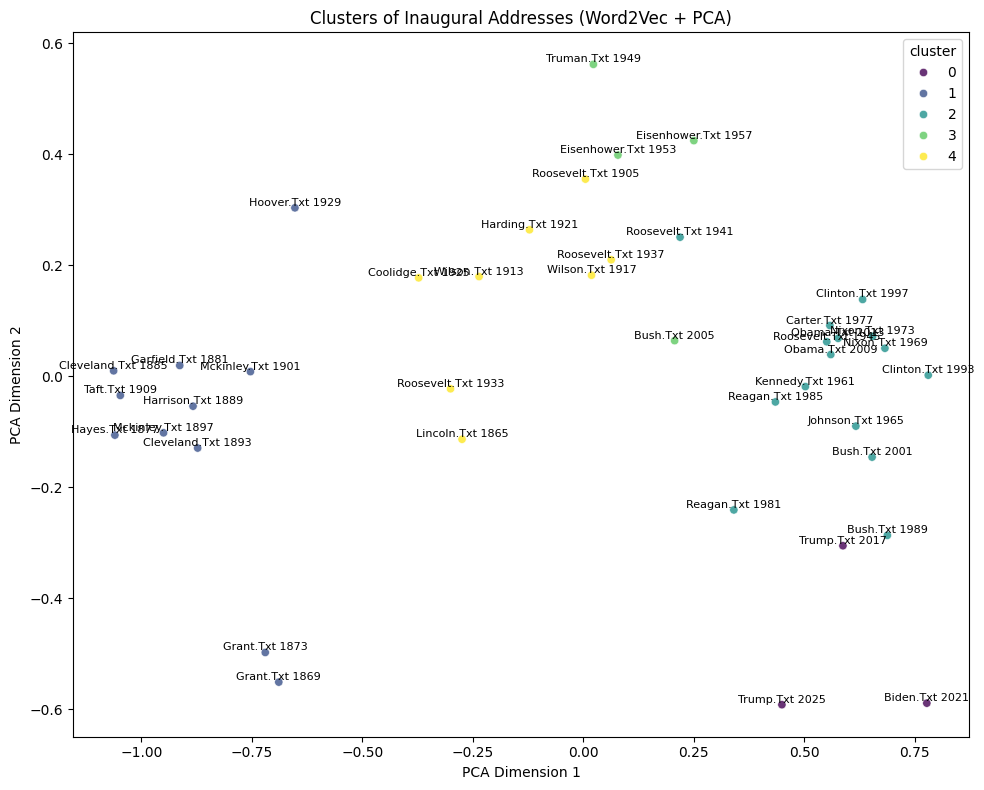

In [50]:
clustered_df, word2vec_model = cluster_speeches_with_word2vec(inaugural_df, n_clusters=5) #changed n_clusters

plot_clusters_pca(clustered_df, word2vec_model)


## 5B. Topic Modeling

An alternative approach is to apply LDA for topic modeling

In [ ]:
from gensim.corpora import Dictionary
#import latent dirichlet algo from gensim
from gensim.models import LdaModel


In [52]:

def plot_top_words(model, feature_names, n_top_words, title):
    """
    Plots the top words for each topic in an LDA model.

    Args:
        model (LdaModel): Trained LDA model.
        feature_names (list): List of feature names (words).
        n_top_words (int): Number of top words to display for each topic.
        title (str): Title of the plot.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.get_topics()): # changed model.components_ to model.get_topics()
        top_features_ind = topic.argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_features_ind]

        ax = axes[topic_idx]
        ax.barh(range(n_top_words), topic[top_features_ind], align='center')
        ax.set_yticks(np.arange(n_top_words))
        ax.set_yticklabels(top_words, fontsize=14)
        ax.invert_yaxis()
        ax.set_xlabel('Weight', fontsize=14)
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=16)
        ax.set_xlim(0, np.max(topic[top_features_ind]))

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

In [ ]:
def run_lda_topic_modeling(df, num_topics=4):
    """
    Applies LDA topic modeling to the input DataFrame, prints the top words
    for each topic, and displays word clouds for each topic.

    Args:
        df (pd.DataFrame): DataFrame containing the 'speech_text' column.
        num_topics (int, optional): The number of topics to generate. Defaults to 4.
    """
    # 1. Prepare the data
    cleaned_speeches = [tidytext_clean(text) for text in df['speech_text']]

    # 2. Create a dictionary of terms and corpus
    dictionary = Dictionary([speech.split() for speech in cleaned_speeches])
    #doc2bow is bag of words
    corpus = [dictionary.doc2bow(speech.split()) for speech in cleaned_speeches]


    # 3. Train the LDA model
    #
    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, random_state=2024) # Changed order of args

    # 4. Print the top words for each topic
    num_top_words = 10  # Number of top words to display
    feature_names = [dictionary[i] for i in range(len(dictionary))]  # Get word list
    plot_top_words(lda_model, feature_names, num_top_words, "Top Words in Each Topic")

    return lda_model, dictionary, corpus # return the model, corpus, dictionary.


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# 3. Feature Extraction: Use TF-IDF to convert text to numerical vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(inaugural_df['speech_text']
                                        )

# Topic Modeling: Apply LDA
num_topics = 4
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Display the topics and top words
feature_names = vectorizer.get_feature_names_out()

print(f"\nTopic Model (k={num_topics}):")
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

# 6. Assign topics to each speech (optional)
topic_assignments = lda_model.transform(tfidf_matrix).argmax(axis=1)
inaugural_df['topic'] = topic_assignments

print("\nDataFrame with assigned topics:")
print(inaugural_df.head())


Topic Model (k=4):
Topic 1: people, government, america, world, nation, new, peace, freedom, shall, great
Topic 2: manger, smoothly, ostriches, valleys, downward, faintness, anguished, 1945, emerson, peabody
Topic 3: faintness, schoolmaster, anguished, emerson, 1945, valleys, smoothly, peabody, ostriches, solid
Topic 4: 1945, emerson, schoolmaster, valleys, solid, ostriches, anguished, stout, faintness, untroubled

DataFrame with assigned topics:
                                         speech_text          president  \
0  Fellow-Countrymen:\n\nAt this second appearing...   Lincoln.Txt 1865   
1  Citizens of the United States:\n\nYour suffrag...     Grant.Txt 1869   
2  Fellow-Citizens:\n\nUnder Providence I have be...     Grant.Txt 1873   
3  Fellow citizens, we have assembled to repeat t...     Hayes.Txt 1877   
4  Fellow-Citizens:\n\nWe stand to-day upon an em...  Garfield.Txt 1881   

   speech_id  cluster  topic  
0          1        4      0  
1          2        1      0  
2   